<a href="https://colab.research.google.com/github/tjrgh822/class_itsystem/blob/master/hw2/hw2_relu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import numpy.random as rd
import sys
import matplotlib.pyplot as plt
import time

rd.seed(777)

dataset_num = 2000
variance = 0.4
wtflag = 0
file_exist = False


# making dataset
def making_data_set(d_num):
    d_set = np.empty(1)
    if file_exist:
        tmp = np.load(sys.argv[1])
        d_set = np.append(d_set, tmp)
    else:
        for i in range(int(d_num)):
            b0 = int(rd.randint(0, 2, 1))
            b1 = int(rd.randint(0, 2, 1))
            b2 = int(rd.randint(0, 2, 1))

            x = rd.normal(b0 * 2 - 1, variance)
            y = rd.normal(b1 * 2 - 1, variance)
            z = rd.normal(b2 * 2 - 1, variance)

            result = b0 + b1 + b2

            rb0 = result % 2
            rb1 = int(result / 2) % 2
            d_set = np.append(d_set, [[x, y, z, rb0, rb1]])
            '''x = rd.randint(0, 2, 1)
            y = rd.randint(0, 2, 1)
            rst = x | y

            d_set = np.append(d_set, [x, y, rst])'''
    d_set = np.delete(d_set, 0, axis=0)
    d_set = d_set.reshape(-1, 5)
    # d_set = d_set.reshape(-1, 3)
    return d_set


t_data = making_data_set(dataset_num).astype(np.float32)
t_x_data = t_data[:, 0:-2]
t_y_data = t_data[:, -2:].reshape(-1, 2)

test_data = making_data_set(100).astype(np.float32)
test_x_data = test_data[:, 0:-2]
test_y_data = test_data[:, -2:].reshape(-1, 2)

'''t_data = making_data_set()
t_x_data = t_data[:, 0:-1]
t_y_data = t_data[:, -1].reshape(-1, 1)

test_data = making_data_set()
test_x_data = t_data[:, 0:-1]
test_y_data = t_data[:, -1].reshape(-1, 1)'''

print(f"x test data : \n{t_x_data.shape}\n y test data : \n {t_y_data.shape}\n")



In [0]:
'''
layer class 는 hidden node를 관리하기 위한 class로써
(1) activation function과  (2) derivate activation function의 구현과
(3) weight value를 저장한다.
'''

class layer_class:
  #sigmoid, relu 구현
    def sigmoid(self, a):
        return 1 / (1 + np.exp(-a))

    def relu(self, b):
        return np.where(b < 0, 0, b)

    def dsigmoid(self, a):
        return a * (1 - a)

    def drelu(self, a):
        return np.where(a < 0, 0, 1)

    w = np.array([]);
    bias = 'False';
    ftn = sigmoid;
    dftn = dsigmoid;
    b = np.array([]);
    dataflow = np.array([]);
    delta = np.array([])

#string으로 받아서 bias와 weight값 구현
    def __init__(self, w, bias='False', activation='sigmoid'):
        self.w = w
        if bias == 'True':
            self.bias = 'True'
            self.b = np.zeros((1, w.shape[1]))
        else:
            self.bias = 'False'
        if activation == 'sigmoid':
            self.ftn = self.sigmoid
            self.dftn = self.dsigmoid
        elif activation == 'relu':
            self.ftn = self.relu
            self.dftn = self.drelu
rd.seed(770)

'''
NN class 는 DNN위해 필요한 함수(gradient decent, forward)를 전부 구현하였고,
추가로 데이터 저장을 위해 각 accuracy, cost, weight value값 등을 epoch별로 저장하는
list를 만들었다.

'''

class NN:
    train_set_x, train_set_y, test_set_x, test_set_y, learning_rate, end_learning_rate, activate = np.array([]), np.array([]), np.array([]), np.array([]), 0, 0, 'sigmoid'
    layer, train_loss, test_loss, train_accuracy, test_accuracy = [], [], [], [], []
    feature = []
    batch = 1
    # 추적
    weight_hist = []
    delta_hist = []
    bias_hist = []

    def __init__(self, train_set_x, train_set_y, test_set_x, test_set_y, feature, learning_rate=0.01, \
                 end_learning_rate=0.01, batch=1):
        self.learning_rate = learning_rate
        self.end_learning_rate = end_learning_rate
        self.train_set_x = train_set_x
        self.train_set_y = train_set_y
        self.test_set_x = test_set_x
        self.test_set_y = test_set_y
        self.feature = feature
        self.batch = batch
        self.layer = []
        self.layer, self.train_loss, self.test_loss, self.train_accuracy, self.test_accuracy = [], [], [], [], []
        self.weight_hist = []
        self.delta_hist = []
        self.bias_hist = []
        # w initialization sigmoid use xavier initialization  Relu using He initialization
        for i, f in enumerate(self.feature):
            if i == (len(self.feature) - 1):
                break
            w = 0
            if f[2] is 'sigmoid':
                # w = rd.randn(f[0], int(self.feature[i + 1][0])) * np.sqrt(1 / (f[0] + self.feature[i + 1][0]))
                w = rd.randn(f[0], int(self.feature[i + 1][0])) * np.sqrt(1 / (f[0])) # 새로 고안된 he initialization
            elif f[2] is 'relu':
                # w = rd.randn(f[0], int(self.feature[i + 1][0])) * np.sqrt(2 / (f[0] + self.feature[i + 1][0])) 예전 he initialization
                w = rd.randn(f[0], int(self.feature[i + 1][0])) * np.sqrt(2 / (f[0])) # 새로 고안된 he initialization
            self.layer.append(layer_class(w, f[1], f[2]))

    def forwarding(self, x_data, y_data):
        for i, k in enumerate(self.layer):
            a = np.array([])
            # 첫단에만 input 과 weight를 곱
            if i == 0:
                a = np.append(a, np.dot(x_data, k.w)).reshape(x_data.shape[0], k.w.shape[1])
            #다음단 부터 그 전단의 output과 weight를 곱
            else:
                a = np.append(a, np.dot(self.layer[i - 1].dataflow, k.w)).reshape(x_data.shape[0], k.w.shape[1])
            # bias 추가
            if k.bias == 'True':
                a = np.multiply(np.ones((int(x_data.shape[0]), int(k.w.shape[1]))), k.b) + a
            k.dataflow = k.ftn(a)
            #print(f"{i}'s output : {k.dataflow.shape}'")

    def backpropagation(self, x_data, y_data, lr):
        for i, L in reversed(list(enumerate(self.layer))):
            # delta구하기, 마지막 단만 cross entropy derivation 값
            L.before_w = L.w
            L.delta = y_data - L.dataflow if i is (len(self.layer) - 1) \
                else np.multiply(L.dftn(L.dataflow), \
                                 np.dot(self.layer[i + 1].delta, self.layer[i + 1].before_w.T))

            # input layer 이면 input data가 train_set
            inputt = x_data if i == 0 else self.layer[i - 1].dataflow

            '''x_k * delta -> upgrade할 weight'''
            upgrade_w = np.array([np.outer(inputt[k], L.delta[k]) for k in range(L.delta.shape[0])]) \
                .reshape(-1, L.w.shape[0], L.w.shape[1])

            """update bias"""
            if L.bias == 'True':
                L.b = L.b + L.delta * self.learning_rate
            """update weight"""
            L.w = L.w + np.average(upgrade_w, axis=0) * self.learning_rate

    def training(self, epochs):
      #SGD 구현, 여기 batch는 사실 정확한 정의로는 iteration이다.
        for i in range(epochs):
            for j in range(self.batch):
                x_data = self.train_set_x[
                         int(len(self.train_set_x) / self.batch) * j: int(len(self.train_set_x) / self.batch) * (j + 1),
                         :]
                y_data = self.train_set_y[
                         int(len(self.train_set_y) / self.batch) * j: int(len(self.train_set_y) / self.batch) * (j + 1),
                         :]
                lr = self.learning_rate + (self.end_learning_rate - self.learning_rate) / epochs
                self.forwarding(x_data, y_data)
                self.backpropagation(x_data, y_data, lr)
            self.data_save(self.test_set_x, self.test_set_y)

            if i % 50 == 0:
                print(
                    f"epochs : {i}\t train_loss :{self.train_loss[i]:.4}\t test_loss :{self.test_loss[i]:.4}\t train_accuracy :{self.train_accuracy[i]:.3}%\t test_accuracy :{self.test_accuracy[i]:.3}%")

    def plot(self):
        # loss plot 
        plt.figure()
        plt.plot(self.train_loss, 'b')
        plt.plot(self.test_loss, 'r')
        plt.show()
        # accuracy plot
        plt.figure()
        plt.plot(self.train_accuracy, 'b')
        plt.plot(self.test_accuracy, 'r')
        plt.show()

        ''' plt.figure()
        plt.plot(self.weight_hist)
        plt.plot(self.delta_hist)
        plt.show()'''

        plt.figure()
        plt.plot(self.bias_hist)
        plt.show()

    # test accuracy와 loss를 구하기 위한 함수. 여기에서 train acc 와 train loss도 같이 hist에 append한다.
    def data_save(self, x_data, y_data):
        # train loss, accuracy 구하기
        predict = self.layer[-1].dataflow
        y = self.train_set_y[-int(len(self.train_set_y) / self.batch):, :]

        # cross entropy
        train_loss = np.average(-(y * np.log(predict + 1e-7) + (1 - y) * np.log(1 - predict + 1e-7)))
        self.train_loss.append(train_loss)

        train_result = np.equal(y, np.array([self.layer[-1].dataflow > result_mean]))
        train_correct = np.average(train_result) * 100
        self.train_accuracy.append(train_correct)

        for i, k in enumerate(self.layer):
            a = np.array([])
            if i is 0:
                a = np.append(a, np.dot(x_data, k.w))
            else:
                a = np.append(a, np.dot(self.layer[i - 1].dataflow, k.w))

            a = a.reshape(self.test_set_x.shape[0], k.w.shape[1])
            # print(a.shape)
            k.dataflow = k.ftn(a)

            if i == 0:
                self.weight_hist.append(k.w.reshape(-1))
                self.delta_hist.append(k.delta.reshape(-1))
                if k.bias is "True":
                    self.bias_hist.append(k.b.reshape(-1))

        self.test_loss = np.append(self.test_loss, np.average((self.layer[-1].dataflow - y_data) ** 2))

        # print(self.layer[-1].dataflow)
        # result = np.array([self.layer[-1].dataflow > 0.5])
        result = np.array([self.layer[-1].dataflow > result_mean])
        cnt = np.equal(self.test_set_y, result)
        # print(f"ny_data : \n{self.test_set_y}\n\n y^ : \n{self.layer[-1].dataflow}")
        correct = np.average(cnt) * 100
        self.test_accuracy.append(correct)


===================  S : 0 ====================
epochs : 0	 train_loss :0.7695	 test_loss :0.2845	 train_accuracy :43.2%	 test_accuracy :45.5%
epochs : 50	 train_loss :0.5154	 test_loss :0.1904	 train_accuracy :80.8%	 test_accuracy :75.0%
epochs : 100	 train_loss :0.3753	 test_loss :0.1321	 train_accuracy :88.8%	 test_accuracy :88.0%
epochs : 150	 train_loss :0.3071	 test_loss :0.1108	 train_accuracy :90.8%	 test_accuracy :90.5%
epochs : 200	 train_loss :0.2661	 test_loss :0.09975	 train_accuracy :93.8%	 test_accuracy :90.0%
epochs : 250	 train_loss :0.237	 test_loss :0.0914	 train_accuracy :94.2%	 test_accuracy :90.0%
epochs : 300	 train_loss :0.2135	 test_loss :0.08381	 train_accuracy :96.0%	 test_accuracy :90.0%
epochs : 350	 train_loss :0.1927	 test_loss :0.07643	 train_accuracy :96.5%	 test_accuracy :90.5%
epochs : 400	 train_loss :0.1734	 test_loss :0.06986	 train_accuracy :97.2%	 test_accuracy :92.5%
epochs : 450	 train_loss :0.1561	 test_loss :0.06479	 train_accuracy :97.5%	 te

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in exp
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:169: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in greater


epochs : 550	 train_loss :nan	 test_loss :nan	 train_accuracy :48.8%	 test_accuracy :48.0%
epochs : 600	 train_loss :nan	 test_loss :nan	 train_accuracy :48.8%	 test_accuracy :48.0%
epochs : 650	 train_loss :nan	 test_loss :nan	 train_accuracy :48.8%	 test_accuracy :48.0%
epochs : 700	 train_loss :nan	 test_loss :nan	 train_accuracy :48.8%	 test_accuracy :48.0%
epochs : 750	 train_loss :nan	 test_loss :nan	 train_accuracy :48.8%	 test_accuracy :48.0%
===================  S : 6 ====================
epochs : 0	 train_loss :0.5515	 test_loss :0.1817	 train_accuracy :75.0%	 test_accuracy :79.0%
epochs : 50	 train_loss :0.1095	 test_loss :0.04767	 train_accuracy :97.5%	 test_accuracy :93.5%
epochs : 100	 train_loss :0.07569	 test_loss :0.04051	 train_accuracy :97.8%	 test_accuracy :94.5%
epochs : 150	 train_loss :0.09206	 test_loss :0.03946	 train_accuracy :97.2%	 test_accuracy :94.5%
epochs : 200	 train_loss :0.1124	 test_loss :0.04255	 train_accuracy :96.8%	 test_accuracy :94.5%
epochs : 

/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:906: RuntimeWarning: overflow encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:906: RuntimeWarning: invalid value encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)


epochs : 650	 train_loss :nan	 test_loss :nan	 train_accuracy :48.8%	 test_accuracy :48.0%
epochs : 700	 train_loss :nan	 test_loss :nan	 train_accuracy :48.8%	 test_accuracy :48.0%
epochs : 750	 train_loss :nan	 test_loss :nan	 train_accuracy :48.8%	 test_accuracy :48.0%
===================  S : 9 ====================
epochs : 0	 train_loss :0.5381	 test_loss :0.1775	 train_accuracy :79.5%	 test_accuracy :77.0%
epochs : 50	 train_loss :0.05074	 test_loss :0.04695	 train_accuracy :99.0%	 test_accuracy :95.0%
epochs : 100	 train_loss :0.03501	 test_loss :0.04816	 train_accuracy :98.8%	 test_accuracy :94.5%
epochs : 150	 train_loss :0.04724	 test_loss :0.05161	 train_accuracy :99.2%	 test_accuracy :94.5%
epochs : 200	 train_loss :0.05889	 test_loss :0.05242	 train_accuracy :99.0%	 test_accuracy :94.5%
epochs : 250	 train_loss :0.06473	 test_loss :0.05133	 train_accuracy :99.0%	 test_accuracy :94.5%
epochs : 300	 train_loss :0.08252	 test_loss :0.05123	 train_accuracy :97.0%	 test_accurac

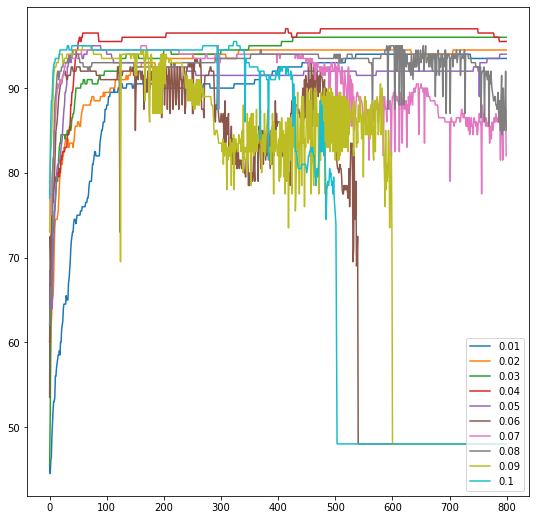

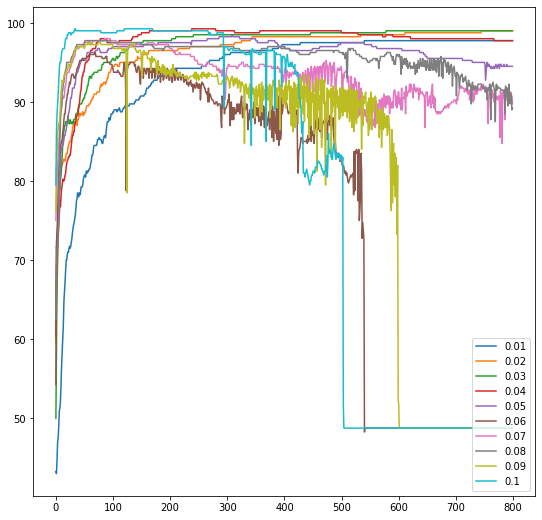

In [0]:

nn_list = []

for s in range(10):
    epochs = 800
    batch = 10
    learning_rate = 0.001 + s * 0.003
    end_learning_rate = 0.001 + s * 0.003
    result_mean = 0.5

    nn_list.append(NN(t_x_data, t_y_data, test_x_data, test_y_data, \
            [[3, 'True', 'relu'], [30, 'True', 'relu'],[30, 'True', 'relu'],[30, 'True', 'relu'], [30, 'True', 'sigmoid'],\
            [2, 'False', 'sigmoid']], \
            learning_rate=learning_rate, batch=batch))
    print(f"===================  S : {s} ====================")
    nn_list[s].training(epochs)

plt.figure(figsize = (9, 9))
for i in range(len(nn_list)):
    plt.plot(nn_list[i].test_accuracy,label = f'{0.001+ i*0.003:.4}')
plt.legend(loc = 'lower right')
plt.show()

plt.figure(figsize = (9, 9))
for i in range(len(nn_list)):
    plt.plot(nn_list[i].train_accuracy,label = f'{0.001+ i*0.003:.4}')
plt.legend(loc = 'lower right')
plt.show()


===================  S : 0 ====================
epochs : 0	 train_loss :0.712	 test_loss :0.2654	 train_accuracy :48.5%	 test_accuracy :45.0%
epochs : 50	 train_loss :0.3421	 test_loss :0.1362	 train_accuracy :81.5%	 test_accuracy :83.0%
epochs : 100	 train_loss :0.3077	 test_loss :0.1076	 train_accuracy :83.2%	 test_accuracy :88.5%
epochs : 150	 train_loss :0.3114	 test_loss :0.1123	 train_accuracy :83.8%	 test_accuracy :85.0%
epochs : 200	 train_loss :0.3042	 test_loss :0.1007	 train_accuracy :84.0%	 test_accuracy :88.0%
epochs : 250	 train_loss :0.2948	 test_loss :0.0979	 train_accuracy :87.2%	 test_accuracy :86.5%
epochs : 300	 train_loss :0.2969	 test_loss :0.1008	 train_accuracy :86.2%	 test_accuracy :86.5%
epochs : 350	 train_loss :0.3385	 test_loss :0.09571	 train_accuracy :84.0%	 test_accuracy :87.0%
epochs : 400	 train_loss :0.3123	 test_loss :0.1137	 train_accuracy :84.8%	 test_accuracy :81.5%
epochs : 450	 train_loss :0.3115	 test_loss :0.125	 train_accuracy :85.0%	 test_ac

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in exp
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:169: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in greater


===================  S : 4 ====================
epochs : 0	 train_loss :0.7226	 test_loss :0.2686	 train_accuracy :46.2%	 test_accuracy :45.5%
epochs : 50	 train_loss :0.1617	 test_loss :0.06661	 train_accuracy :95.5%	 test_accuracy :91.0%
epochs : 100	 train_loss :0.1195	 test_loss :0.06009	 train_accuracy :96.0%	 test_accuracy :92.0%
epochs : 150	 train_loss :0.1125	 test_loss :0.05674	 train_accuracy :96.0%	 test_accuracy :93.0%
epochs : 200	 train_loss :0.1188	 test_loss :0.05315	 train_accuracy :96.0%	 test_accuracy :94.0%
epochs : 250	 train_loss :0.1265	 test_loss :0.05039	 train_accuracy :95.8%	 test_accuracy :94.5%
epochs : 300	 train_loss :0.1488	 test_loss :0.05	 train_accuracy :94.5%	 test_accuracy :94.5%
epochs : 350	 train_loss :0.1622	 test_loss :0.05206	 train_accuracy :94.0%	 test_accuracy :94.0%
epochs : 400	 train_loss :0.1683	 test_loss :0.05566	 train_accuracy :93.2%	 test_accuracy :93.5%
epochs : 450	 train_loss :0.1736	 test_loss :0.06368	 train_accuracy :94.2%	 

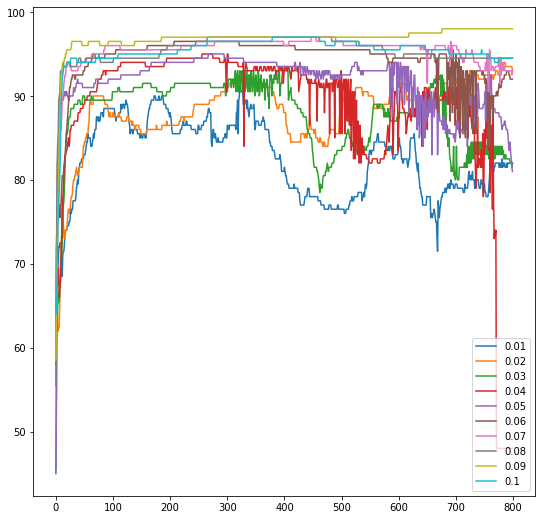

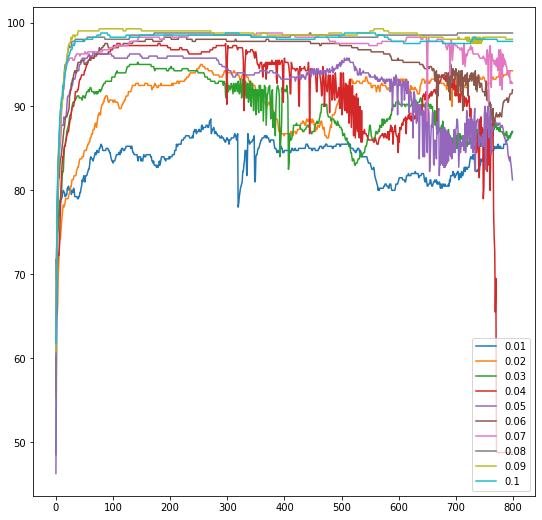

In [0]:

nn_list_node = []

for s in range(10):
    epochs = 800
    batch = 10
    learning_rate = 0.014
    end_learning_rate = 0.014
    result_mean = 0.5

    nn_list_node.append(NN(t_x_data, t_y_data, test_x_data, test_y_data, \
            [[3, 'True', 'relu'], [10 + s*5, 'True', 'relu'],[10 + s*5, 'True', 'relu'],[10 + s*5, 'True', 'relu'], [10 + s*5, 'True', 'sigmoid'],\
            [2, 'False', 'sigmoid']], \
            learning_rate=learning_rate, batch=batch))
    print(f"===================  S : {s} ====================")
    nn_list_node[s].training(epochs)

plt.figure(figsize = (9, 9))
for i in range(len(nn_list_node)):
    plt.plot(nn_list_node[i].test_accuracy,label = f'{10 + i*5:.4}')
plt.legend(loc = 'lower right')
plt.show()

plt.figure(figsize = (9, 9))
for i in range(len(nn_list_node)):
    plt.plot(nn_list_node[i].train_accuracy,label = f'{10 + i*5:.4}')
plt.legend(loc = 'lower right')
plt.show()


===================  S : 0 ====================
epochs : 0	 train_loss :0.6913	 test_loss :0.2518	 train_accuracy :51.5%	 test_accuracy :47.0%
epochs : 50	 train_loss :0.02776	 test_loss :0.002072	 train_accuracy :1e+02%	 test_accuracy :1e+02%
epochs : 100	 train_loss :0.007029	 test_loss :0.0003461	 train_accuracy :1e+02%	 test_accuracy :1e+02%
epochs : 150	 train_loss :0.003384	 test_loss :0.0001363	 train_accuracy :1e+02%	 test_accuracy :1e+02%
epochs : 200	 train_loss :0.002098	 test_loss :7.048e-05	 train_accuracy :1e+02%	 test_accuracy :1e+02%
epochs : 250	 train_loss :0.001474	 test_loss :4.157e-05	 train_accuracy :1e+02%	 test_accuracy :1e+02%
epochs : 300	 train_loss :0.001116	 test_loss :2.675e-05	 train_accuracy :1e+02%	 test_accuracy :1e+02%
epochs : 350	 train_loss :0.000887	 test_loss :1.834e-05	 train_accuracy :1e+02%	 test_accuracy :1e+02%
epochs : 400	 train_loss :0.0007302	 test_loss :1.321e-05	 train_accuracy :1e+02%	 test_accuracy :1e+02%
epochs : 450	 train_loss :0

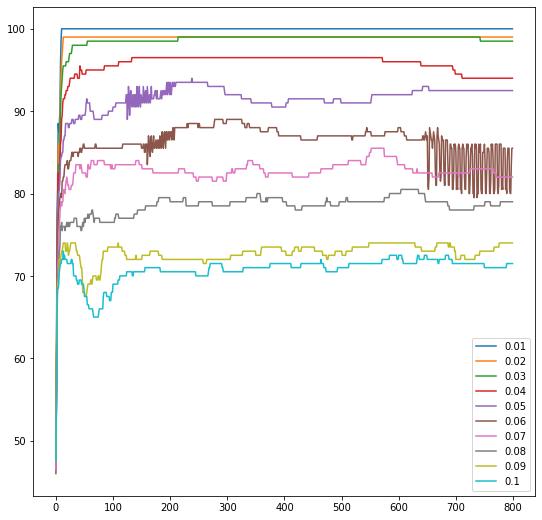

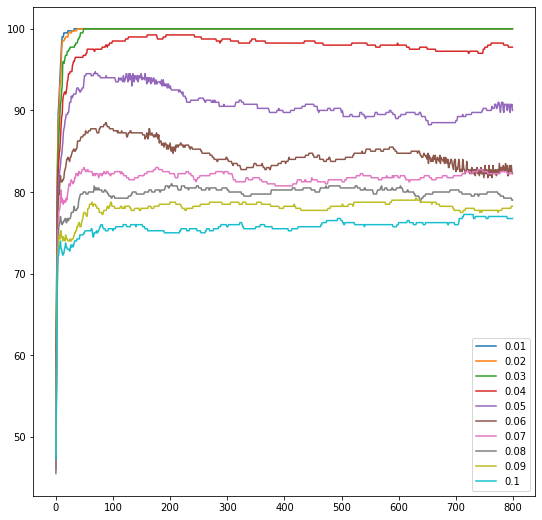

In [0]:
nn_list_variance = []
for s in range(10):
  rd.seed(777)

  dataset_num = 2000
  variance = 0.1 + s*0.1
  wtflag = 0
  file_exist = False

  t_data = making_data_set(dataset_num).astype(np.float32)
  t_x_data = t_data[:, 0:-2]
  t_y_data = t_data[:, -2:].reshape(-1, 2)

  test_data = making_data_set(100).astype(np.float32)
  test_x_data = test_data[:, 0:-2]
  test_y_data = test_data[:, -2:].reshape(-1, 2)

  epochs = 800
  batch = 10
  learning_rate = 0.014
  end_learning_rate = 0.014
  result_mean = 0.5

  nn_list_variance.append(NN(t_x_data, t_y_data, test_x_data, test_y_data, \
          [[3, 'True', 'relu'], [30, 'True', 'relu'],[30, 'True', 'relu'],[30, 'True', 'relu'], [30, 'True', 'sigmoid'],\
          [2, 'False', 'sigmoid']], \
          learning_rate=learning_rate, batch=batch))
  print(f"===================  S : {s} ====================")
  nn_list_variance[s].training(epochs)

plt.figure(figsize = (9, 9))
for i in range(len(nn_list_variance)):
    plt.plot(nn_list_variance[i].test_accuracy,label = f'{0.01*(i+1):.4}')
plt.legend(loc = 'lower right')
plt.show()

plt.figure(figsize = (9, 9))
for i in range(len(nn_list_variance)):
    plt.plot(nn_list_variance[i].train_accuracy,label = f'{0.01*(i+1):.4}')
plt.legend(loc = 'lower right')
plt.show()

